# Analysis of Data Acquired from Trials
- Kaan Borekci

## Imports

In [2]:
import csv
import sys, os, re
import time
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import butter, lfilter, find_peaks

import warnings

## BLOM Trial April 29 2025, Tuesday — TRIAL 2

### Load DataFrame

In [3]:
trial_2 = "/Users/kaanborekci/Library/CloudStorage/OneDrive-NorthwesternUniversity/BME_390-1_Phrenic_Nerve/QUARTER 3/Data Analysis Code/log_01.csv"
blom_trial_2 = pd.read_csv(trial_2)
blom_trial_2

,Time(ms),Acc_x,Acc_y,Acc_z,Gyro_x,Gyro_y,Gyro_z,CO2
0,10,-0.973,-0.102,-0.184,5.725,-1.641,-0.947,0
1,20,-0.989,-0.133,-0.224,6.344,-0.893,0.229,0
2,30,-1.012,-0.103,-0.265,5.641,-0.115,0.344,0
3,40,-0.968,-0.114,-0.198,4.458,-1.511,-0.168,0
4,50,-0.984,-0.114,-0.212,5.931,0.282,0.595,363
...,...,...,...,...,...,...,...,...
36939,369400,-0.996,-0.135,-0.162,-1.237,-4.992,-0.145,565
36940,369410,-0.993,-0.130,-0.172,-1.252,-7.198,-0.298,0
36941,369420,-0.986,-0.131,-0.163,-0.527,-6.756,-0.336,0
36942,369430,-0.973,-0.137,-0.162,-0.328,-6.771,-0.473,0


### Isolate CO2 data
- Get every 5th value from both the CO2 and Time columns
- Convert times in ms to seconds

In [4]:
# Convert time to seconds and extract every 5th time point
time_co2 = pd.DataFrame({'Time(s)': [round(i * 0.001, 2) for i in blom_trial_2["Time(ms)"].iloc[4::5]]})['Time(s)'] 

# Extract every 5th CO2 point
co2_signal = pd.DataFrame({'CO2': blom_trial_2['CO2'].iloc[4::5]})['CO2']


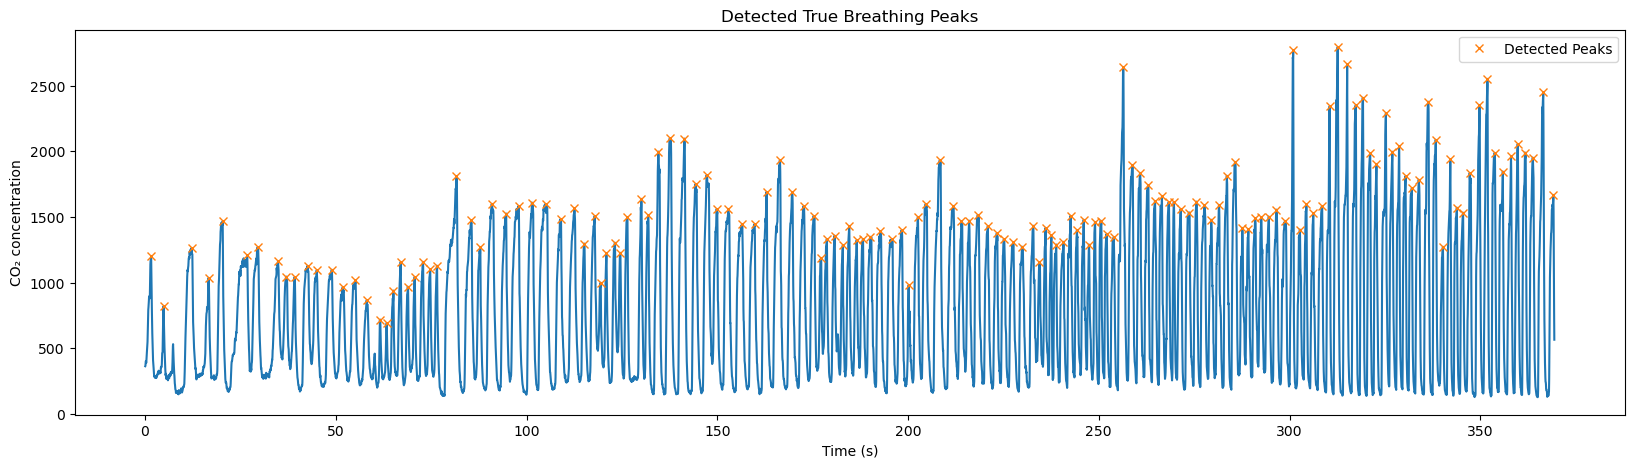

Global Breaths per Minute: 25.02


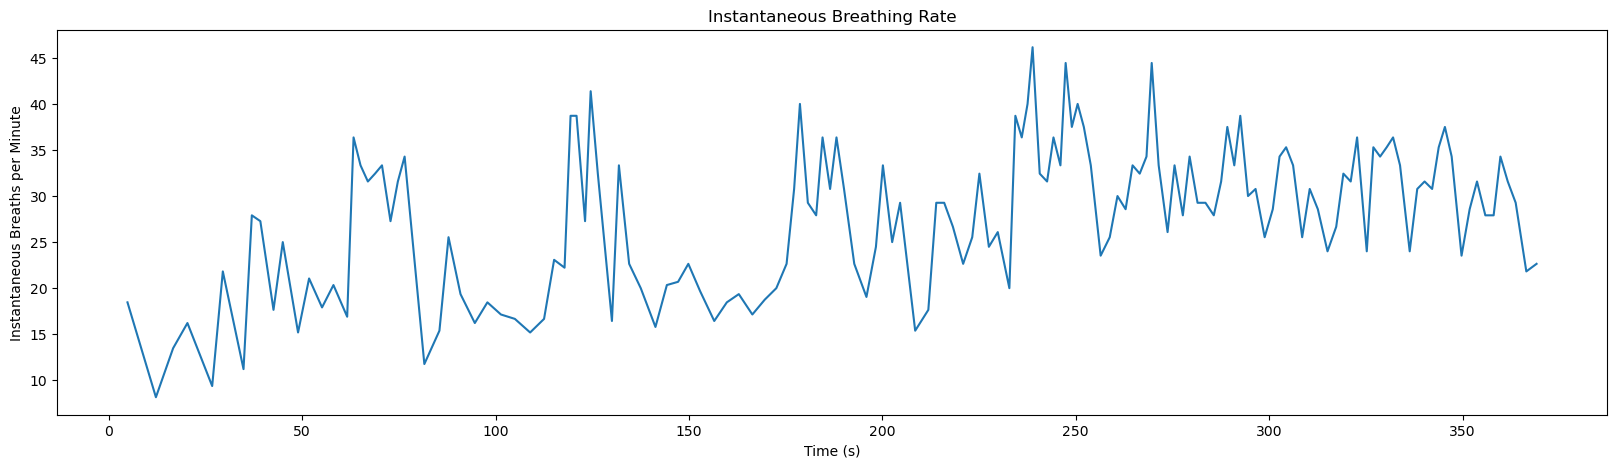

In [13]:
# Plot CO2 Signal

# 1. Detect Peaks directly on the raw CO2 signal, now with prominence
prominence_value = 400  # Adjust this based on your data
peaks, _ = find_peaks(co2_signal, distance=5, prominence=prominence_value)
# distance = 20 samples = 1 second minimum between peaks at 20 Hz

# 2. Plot to verify peak detection
plt.figure(figsize=(20, 5))  # Wider figure for stretched x-axis
plt.plot(time_co2, co2_signal)
plt.plot(time_co2.iloc[peaks], co2_signal.iloc[peaks], "x", label="Detected Peaks")
plt.xlabel('Time (s)')
plt.ylabel('CO₂ concentration')
plt.title('Detected True Breathing Peaks')
plt.legend()
plt.show()

# 3. Calculate Global BPM (breaths per minute)
total_time_co2_minutes = (time_co2.iloc[-1] - time_co2.iloc[0]) / 60
total_breaths = len(peaks)
bpm_global = total_breaths / total_time_co2_minutes
print(f"Global Breaths per Minute: {bpm_global:.2f}")

# 4. Calculate Instantaneous BPM (optional)
peak_time_co2s = time_co2.iloc[peaks].values
intervals_sec = np.diff(peak_time_co2s)  # time_co2 between peaks (seconds)
instantaneous_bpm = 60 / intervals_sec  # convert to bpm

# Plot instantaneous BPM (optional)
plt.figure(figsize=(20,5))
plt.plot(peak_time_co2s[1:], instantaneous_bpm)
plt.xlabel('Time (s)')
plt.ylabel('Instantaneous Breaths per Minute')
plt.title('Instantaneous Breathing Rate')
plt.show()

In [6]:
blom_trial_2

,Time(ms),Acc_x,Acc_y,Acc_z,Gyro_x,Gyro_y,Gyro_z,CO2
0,10,-0.973,-0.102,-0.184,5.725,-1.641,-0.947,0
1,20,-0.989,-0.133,-0.224,6.344,-0.893,0.229,0
2,30,-1.012,-0.103,-0.265,5.641,-0.115,0.344,0
3,40,-0.968,-0.114,-0.198,4.458,-1.511,-0.168,0
4,50,-0.984,-0.114,-0.212,5.931,0.282,0.595,363
...,...,...,...,...,...,...,...,...
36939,369400,-0.996,-0.135,-0.162,-1.237,-4.992,-0.145,565
36940,369410,-0.993,-0.130,-0.172,-1.252,-7.198,-0.298,0
36941,369420,-0.986,-0.131,-0.163,-0.527,-6.756,-0.336,0
36942,369430,-0.973,-0.137,-0.162,-0.328,-6.771,-0.473,0


In [7]:
acc_x = blom_trial_2["Acc_x"]
acc_y = blom_trial_2["Acc_y"]
acc_z = blom_trial_2["Acc_z"]

gyro_x = blom_trial_2["Gyro_x"]
gyro_y = blom_trial_2["Gyro_y"]
gyro_z = blom_trial_2["Gyro_z"]

time_ms = blom_trial_2["Time(ms)"]
time_s = (time_ms * 0.001).round(2)

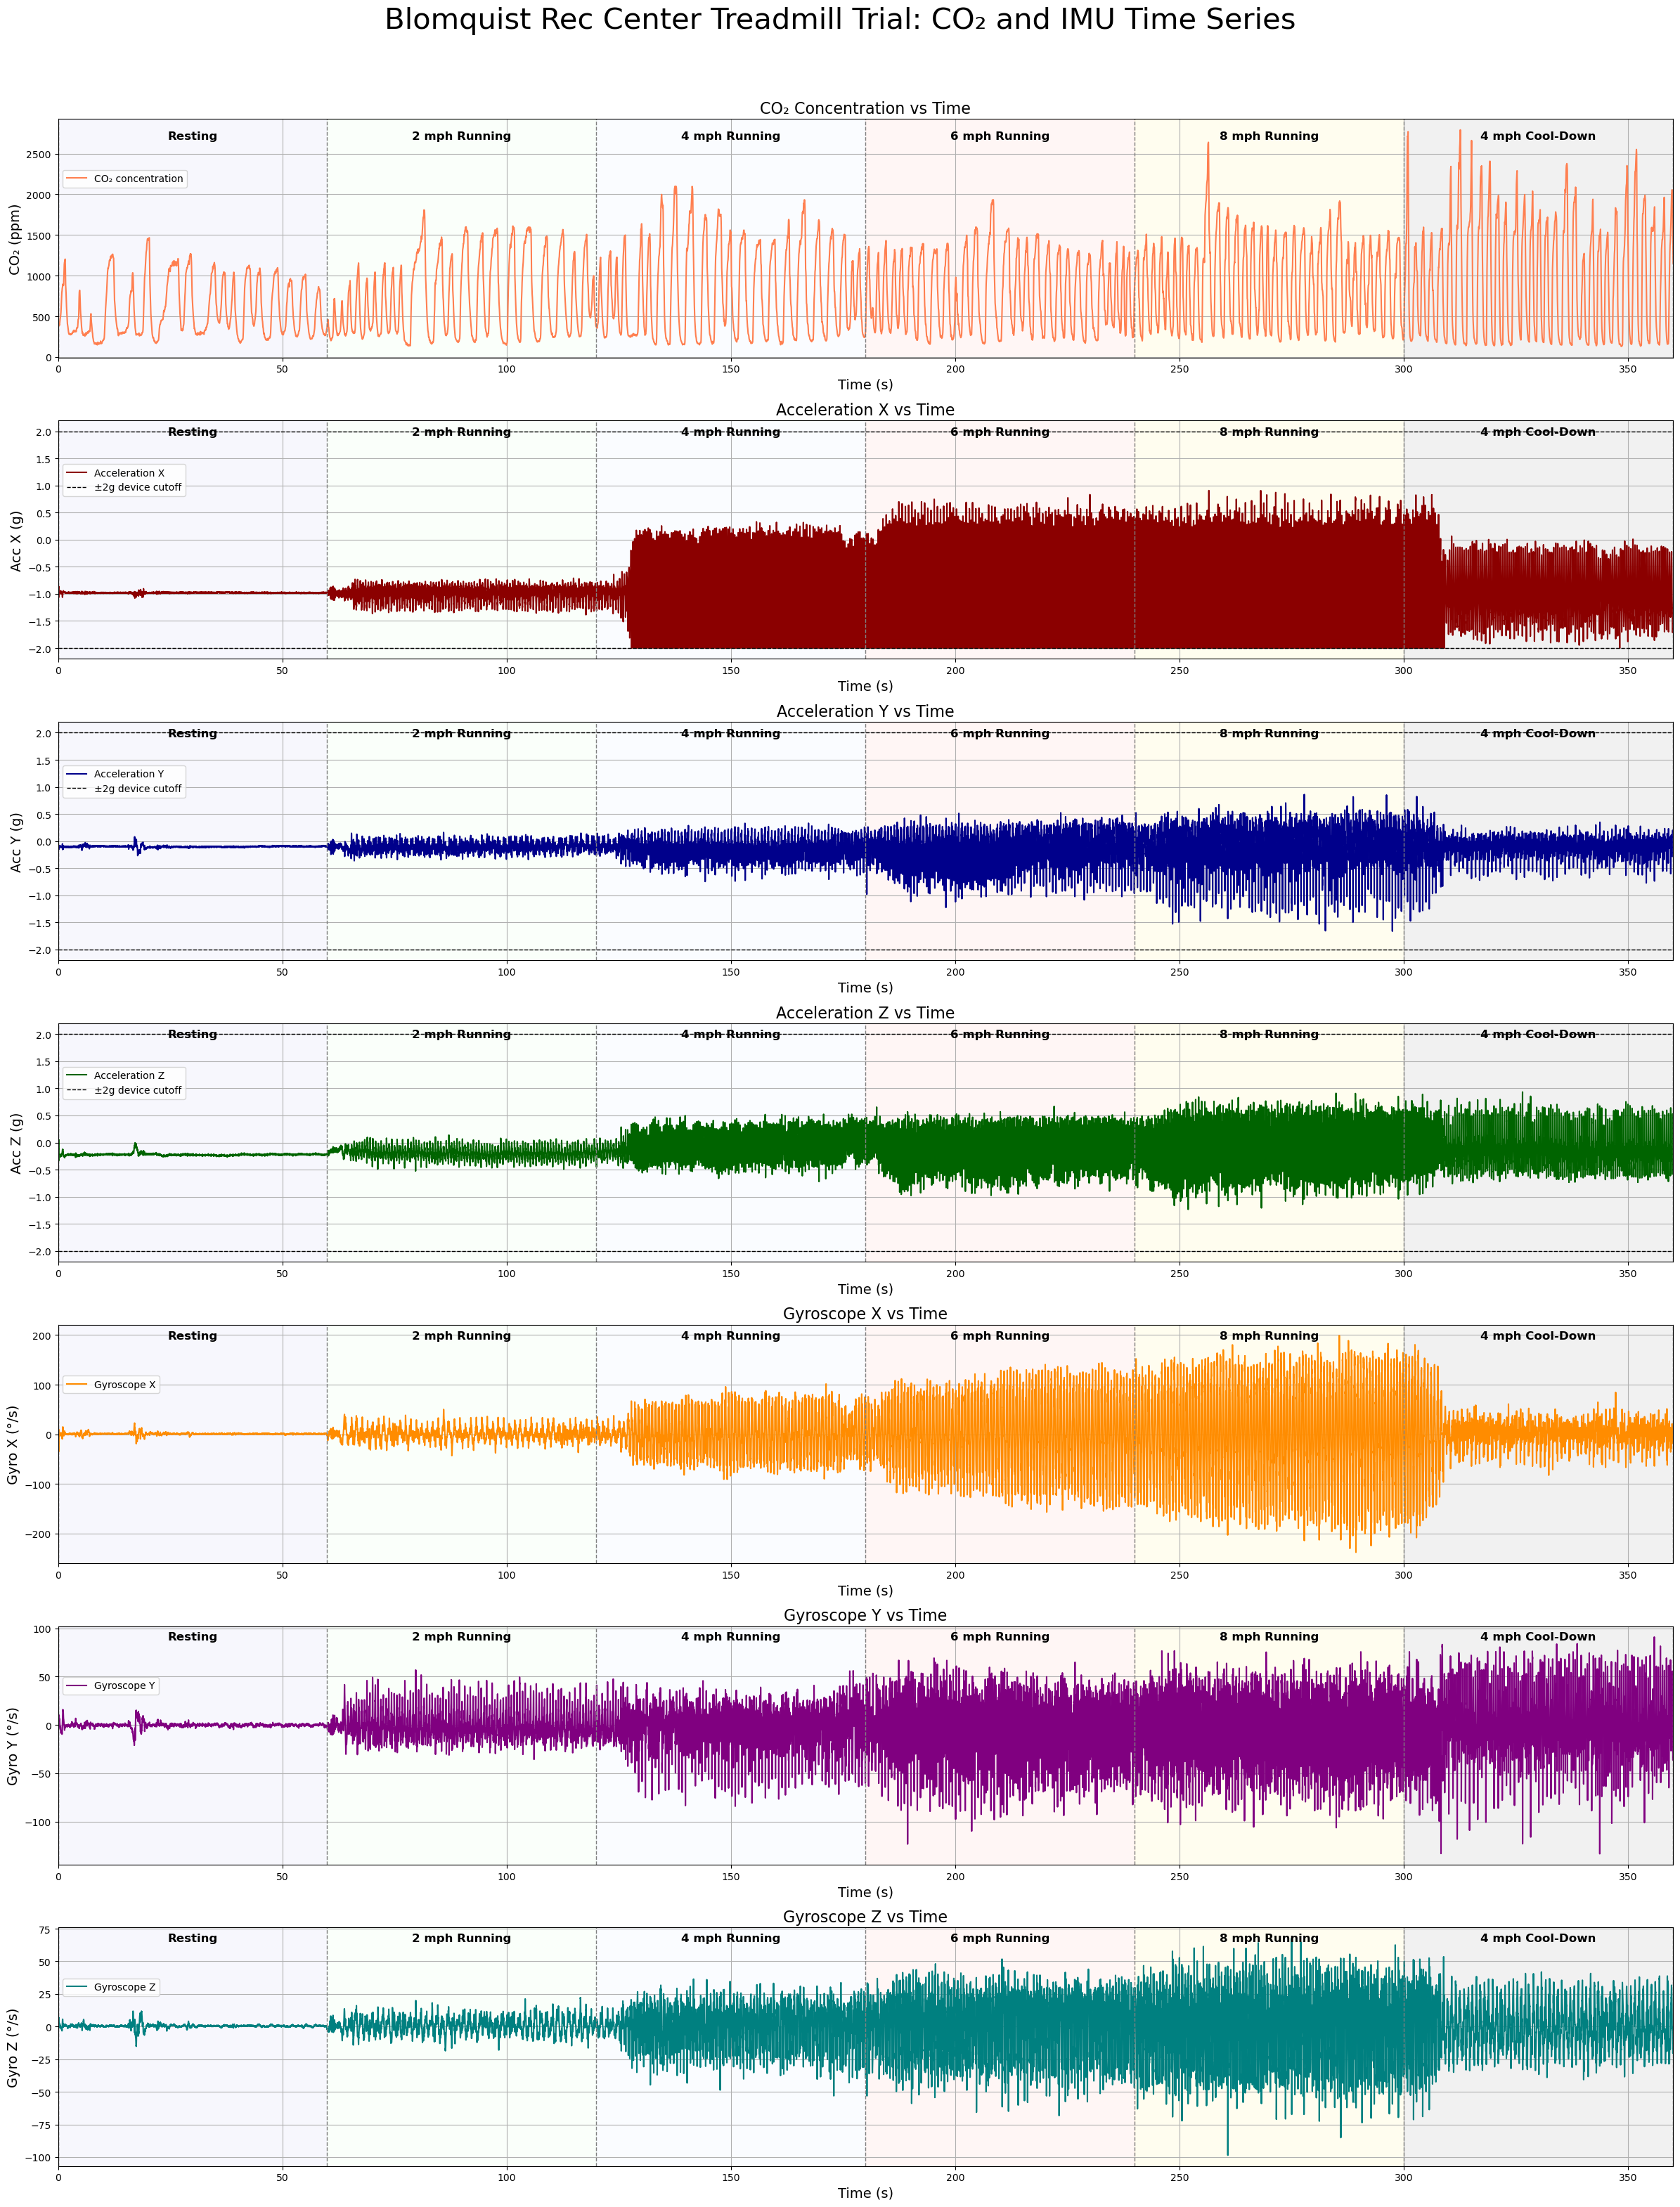

In [12]:
import matplotlib.pyplot as plt

# === Define treadmill phases ===
phase_times = {
    "Resting": (0, 60),
    "2 mph Running": (60, 120),
    "4 mph Running": (120, 180),
    "6 mph Running": (180, 240),
    "8 mph Running": (240, 300),
    "4 mph Cool-Down": (300, 360)
}

phase_colors = {
    "Resting": 'lavender',
    "2 mph Running": 'honeydew',
    "4 mph Running": 'aliceblue',
    "6 mph Running": 'mistyrose',
    "8 mph Running": 'lemonchiffon',
    "4 mph Cool-Down": 'lightgray'
}

# === Helper function to add shaded regions, vertical lines, and labels ===
def add_phase_annotations(ax):
    ylim = ax.get_ylim()
    for label, (start, end) in phase_times.items():
        ax.axvspan(start, end, color=phase_colors[label], alpha=0.3)
        ax.axvline(start, color='gray', linestyle='--', linewidth=1)
        ax.text((start + end) / 2, ylim[1] * 0.95, label,
                ha='center', va='top', fontsize=12, fontweight='bold')
    ax.axvline(360, color='gray', linestyle='--', linewidth=1)
    ax.set_xlim([0, 360])

# === Create figure ===
plt.figure(figsize=(24, 32))  # Wide and tall for 7 stacked plots

# === 1. CO₂ Plot ===
plt.subplot(7, 1, 1)
plt.plot(time_co2, co2_signal, label="CO₂ concentration", color='coral')
add_phase_annotations(plt.gca())
plt.title('CO₂ Concentration vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('CO₂ (ppm)', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.75))
plt.grid()

# === 2. Acc X ===
plt.subplot(7, 1, 2)
plt.plot(time_s, acc_x, label="Acceleration X", color='darkred')
plt.axhline(2, color='black', linestyle='--', linewidth=1, label='±2g device cutoff')
plt.axhline(-2, color='black', linestyle='--', linewidth=1)
add_phase_annotations(plt.gca())
plt.title('Acceleration X vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Acc X (g)', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.75))
plt.grid()

# === 3. Acc Y ===
plt.subplot(7, 1, 3)
plt.plot(time_s, acc_y, label="Acceleration Y", color='darkblue')
plt.axhline(2, color='black', linestyle='--', linewidth=1, label='±2g device cutoff')
plt.axhline(-2, color='black', linestyle='--', linewidth=1)
add_phase_annotations(plt.gca())
plt.title('Acceleration Y vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Acc Y (g)', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.75))
plt.grid()

# === 4. Acc Z ===
plt.subplot(7, 1, 4)
plt.plot(time_s, acc_z, label="Acceleration Z", color='darkgreen')
plt.axhline(2, color='black', linestyle='--', linewidth=1, label='±2g device cutoff')
plt.axhline(-2, color='black', linestyle='--', linewidth=1)
add_phase_annotations(plt.gca())
plt.title('Acceleration Z vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Acc Z (g)', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.75))
plt.grid()

# === 5. Gyro X ===
plt.subplot(7, 1, 5)
plt.plot(time_s, gyro_x, label="Gyroscope X", color='darkorange')
add_phase_annotations(plt.gca())
plt.title('Gyroscope X vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Gyro X (°/s)', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.75))
plt.grid()

# === 6. Gyro Y ===
plt.subplot(7, 1, 6)
plt.plot(time_s, gyro_y, label="Gyroscope Y", color='purple')
add_phase_annotations(plt.gca())
plt.title('Gyroscope Y vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Gyro Y (°/s)', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.75))
plt.grid()

# === 7. Gyro Z ===
plt.subplot(7, 1, 7)
plt.plot(time_s, gyro_z, label="Gyroscope Z", color='teal')
add_phase_annotations(plt.gca())
plt.title('Gyroscope Z vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Gyro Z (°/s)', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.75))
plt.grid()

# === Final title and layout ===
plt.suptitle('Blomquist Rec Center Treadmill Trial: CO₂ and IMU Time Series', fontsize=30)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

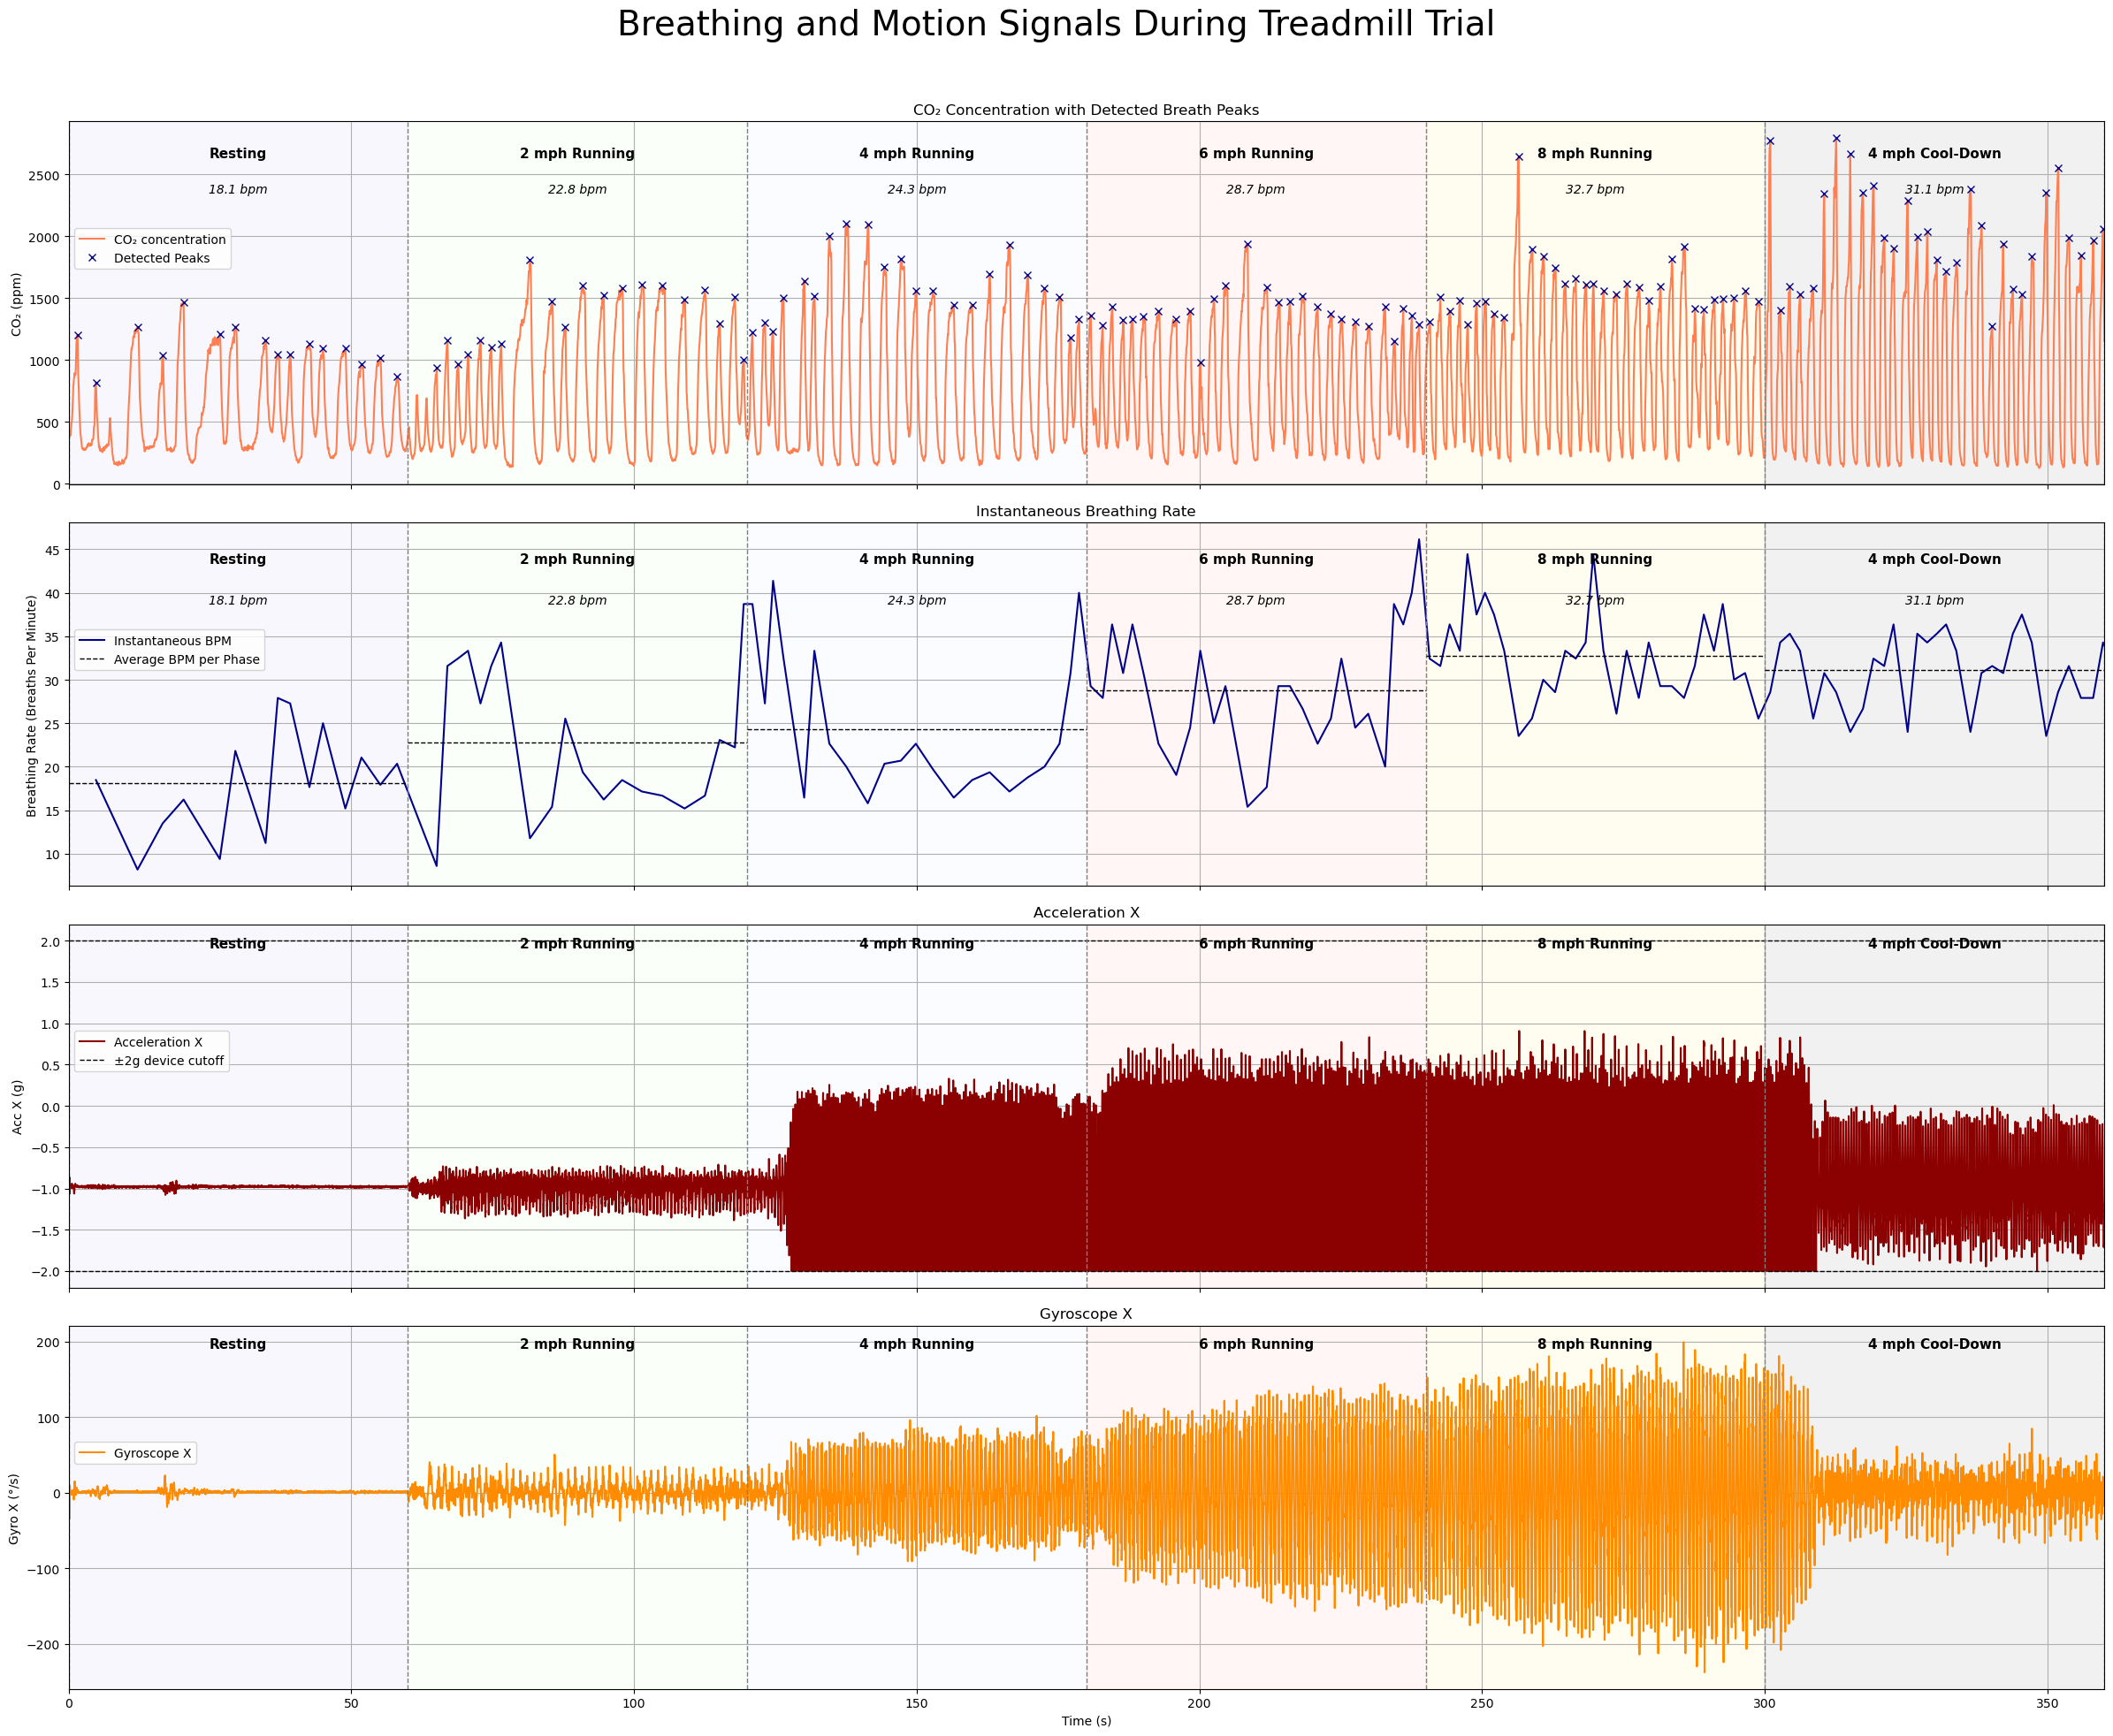

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# === INPUT DATA ===
# Replace these with actual signals from your dataset
# Ensure the following are defined:
# time_co2, co2_signal, time_s, acc_x, gyro_x

# --- Peak Detection ---
prominence_value = 500
peaks, _ = find_peaks(co2_signal, distance=5, prominence=prominence_value)
peak_time_co2s = time_co2.iloc[peaks].values

# --- Instantaneous BPM ---
intervals_sec = np.diff(peak_time_co2s)
instantaneous_bpm = 60 / intervals_sec
bpm_time = peak_time_co2s[1:]

# --- Treadmill Phases ---
phase_times = {
    "Resting": (0, 60),
    "2 mph Running": (60, 120),
    "4 mph Running": (120, 180),
    "6 mph Running": (180, 240),
    "8 mph Running": (240, 300),
    "4 mph Cool-Down": (300, 360)
}

phase_colors = {
    "Resting": 'lavender',
    "2 mph Running": 'honeydew',
    "4 mph Running": 'aliceblue',
    "6 mph Running": 'mistyrose',
    "8 mph Running": 'lemonchiffon',
    "4 mph Cool-Down": 'lightgray'
}

# --- Average BPM per Phase ---
phase_bpm_labels = {}
phase_bpm_values = {}
for label, (start, end) in phase_times.items():
    mask = (bpm_time >= start) & (bpm_time < end)
    avg_bpm = np.mean(instantaneous_bpm[mask]) if np.any(mask) else np.nan
    label_str = f"{avg_bpm:.1f} bpm" if not np.isnan(avg_bpm) else "N/A"
    phase_bpm_labels[label] = label_str
    phase_bpm_values[label] = avg_bpm

# --- Phase Annotation Helper ---
def add_phase_annotations(ax, label_bpm=False, bpm_lines=False, bpm_legend=False):
    ylim = ax.get_ylim()
    for idx, (label, (start, end)) in enumerate(phase_times.items()):
        ax.axvspan(start, end, color=phase_colors[label], alpha=0.3)
        ax.axvline(start, color='gray', linestyle='--', linewidth=1)
        ax.text((start + end) / 2, ylim[1] * 0.93, label,
                ha='center', va='top', fontsize=11, fontweight='bold')
        if label_bpm:
            ax.text((start + end) / 2, ylim[1] * 0.83, phase_bpm_labels[label],
                    ha='center', va='top', fontsize=10, style='italic')
        if bpm_lines and not np.isnan(phase_bpm_values[label]):
            # First time only, add label for legend
            line_label = "Average BPM per Phase" if bpm_legend and idx == 0 else "_nolegend_"
            ax.hlines(phase_bpm_values[label], start, end,
                      color='black', linestyle='--', linewidth=1, label=line_label)
    ax.axvline(360, color='gray', linestyle='--', linewidth=1)
    ax.set_xlim([0, 360])

# === Plotting ===
fig, axs = plt.subplots(4, 1, figsize=(24, 20), sharex=True)

# 1. CO₂ with Peaks
axs[0].plot(time_co2, co2_signal, label="CO₂ concentration", color='coral')
axs[0].plot(time_co2.iloc[peaks], co2_signal.iloc[peaks], "x", label="Detected Peaks", color='darkblue')
axs[0].set_ylabel("CO₂ (ppm)")
axs[0].set_title("CO₂ Concentration with Detected Breath Peaks")
axs[0].legend(loc='center left', bbox_to_anchor=(0, 0.65))
add_phase_annotations(axs[0], label_bpm=True)
axs[0].grid()

# 2. BPM with averages + legend
axs[1].plot(bpm_time, instantaneous_bpm, label="Instantaneous BPM", color='darkblue')
add_phase_annotations(axs[1], label_bpm=True, bpm_lines=True, bpm_legend=True)
axs[1].set_ylabel("Breathing Rate (Breaths Per Minute)")
axs[1].set_title("Instantaneous Breathing Rate")
axs[1].legend(loc='center left', bbox_to_anchor=(0, 0.65))
axs[1].grid()

# 3. Acc X with ±2g lines
axs[2].plot(time_s, acc_x, label="Acceleration X", color='darkred')
axs[2].axhline(2, color='black', linestyle='--', linewidth=1, label='±2g device cutoff')
axs[2].axhline(-2, color='black', linestyle='--', linewidth=1)
axs[2].set_ylabel("Acc X (g)")
axs[2].set_title("Acceleration X")
axs[2].legend(loc='center left', bbox_to_anchor=(0, 0.65))
add_phase_annotations(axs[2])
axs[2].grid()

# 4. Gyro X
axs[3].plot(time_s, gyro_x, label="Gyroscope X", color='darkorange')
axs[3].set_ylabel("Gyro X (°/s)")
axs[3].set_xlabel("Time (s)")
axs[3].set_title("Gyroscope X")
axs[3].legend(loc='center left', bbox_to_anchor=(0, 0.65))
add_phase_annotations(axs[3])
axs[3].grid()

# Final Layout
plt.suptitle("Breathing and Motion Signals During Treadmill Trial", fontsize=28)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()